#Video Game Sales with Ratings
*Cas kaggle*

Gerard Benet Martínez - 1704125
Javier Emparan López - 1704634

---

## Definició del problema

Aquest projecte se centra en l'anàlisi predictiva de l'èxit comercial de videojocs, utilitzant una base de dades que integra una àmplia col·lecció de títols amb les seves mètriques de qualitat extretes principalment de la plataforma Metacritic.

- S'analitzaran les dades i s'aplicara els diferents tractaments de preprocesat per adaptar les dades al problema.
- S'entrenaran distints models i es seleccionar el que doni millors resultats.
- El model haura de ser capaç de predir tant ventes globals com per regio (EU, JP, etc)
---



In [407]:
#importacio de llibreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

from xgboost import XGBRegressor

import kagglehub

In [408]:

# Importacio de les dades directament de Kaggle
path = kagglehub.dataset_download("rush4ratio/video-game-sales-with-ratings")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Video_Games_Sales_as_at_22_Dec_2016.csv")
print(df)
#inicialitzacio de dades importants
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']

print(len(df['Platform'].unique()))

Using Colab cache for faster access to the 'video-game-sales-with-ratings' dataset.
Path to dataset files: /kaggle/input/video-game-sales-with-ratings
                                Name Platform  Year_of_Release         Genre  \
0                         Wii Sports      Wii           2006.0        Sports   
1                  Super Mario Bros.      NES           1985.0      Platform   
2                     Mario Kart Wii      Wii           2008.0        Racing   
3                  Wii Sports Resort      Wii           2009.0        Sports   
4           Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
...                              ...      ...              ...           ...   
16714  Samurai Warriors: Sanada Maru      PS3           2016.0        Action   
16715               LMA Manager 2007     X360           2006.0        Sports   
16716        Haitaka no Psychedelica      PSV           2016.0     Adventure   
16717               Spirits & Spells      GBA    

## Visualització de les dades
En aquesta primera part fem una visualització inicial de les dades per a tenir una millor comprensió del problema i saber com afrontar-lo apropiadament.

In [409]:
#Funcions de visualització de dades
#Mostrar quantitat de NaNs
def mostrarGraficNaNs(dades):
  nan_counts_all = dades.isnull().sum()

  if not nan_counts_all.empty:
      plt.figure(figsize=(12, 6))

      nan_counts_all.plot(kind='bar', color='darkorange')

      plt.title('Quantitat de missing Values (NaN) per atribut', fontsize=16)
      plt.xlabel('Atributs', fontsize=12)
      plt.ylabel('Quantitat de NaNs', fontsize=12)

      for i, v in enumerate(nan_counts_all):
          plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)

      plt.xticks(rotation=45, ha='right')
      plt.grid(axis='y', linestyle='--', alpha=0.7)
      plt.tight_layout()
      plt.show()


In [410]:
print("Nombre d'atributs:", len(df.columns))
print(df.describe())
print(df.info())

Nombre d'atributs: 16
       Year_of_Release      NA_Sales      EU_Sales      JP_Sales  \
count     16450.000000  16719.000000  16719.000000  16719.000000   
mean       2006.487356      0.263330      0.145025      0.077602   
std           5.878995      0.813514      0.503283      0.308818   
min        1980.000000      0.000000      0.000000      0.000000   
25%        2003.000000      0.000000      0.000000      0.000000   
50%        2007.000000      0.080000      0.020000      0.000000   
75%        2010.000000      0.240000      0.110000      0.040000   
max        2020.000000     41.360000     28.960000     10.220000   

        Other_Sales  Global_Sales  Critic_Score  Critic_Count    User_Count  
count  16719.000000  16719.000000   8137.000000   8137.000000   7590.000000  
mean       0.047332      0.533543     68.967679     26.360821    162.229908  
std        0.186710      1.547935     13.938165     18.980495    561.282326  
min        0.000000      0.010000     13.000000      

Per una part, podem veure que hi ha tant dades categoriques com dades no categoriques.
- Per la part de dades categoriques estan la plataforma on s'ha publicat el joc (platform), el genere del joc, el publisher, la desenvolupadora i el rating. També podem veure que el user_score no surt com a numeric, pero per que hi ha valors "tbd", els cuals haurem de tractar mes endavant.

- Per la part de dades no categoriques trobem l'any de publicació del joc, les ventes tant en NA, EU, JP, globals i altres, els tipus de valoració que hi ha, tant per la part de critics com d'usuari.

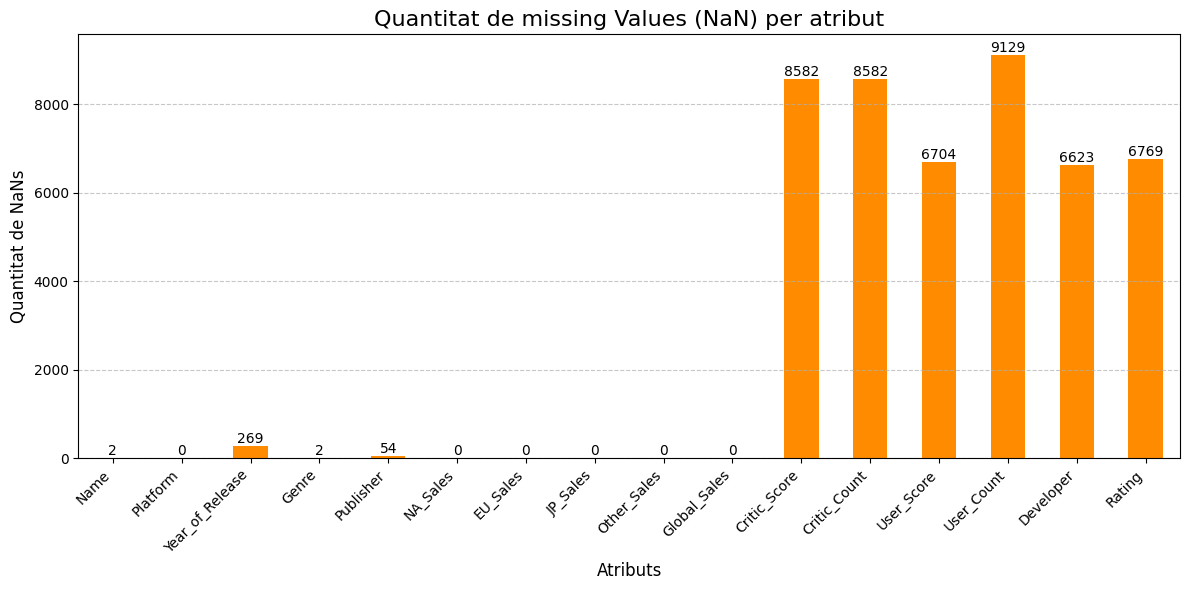

In [411]:
mostrarGraficNaNs(df)

Podem destacar que hi ha una gran quantitat de NaNs en les categories de valoracions (critic/user score i critic/user count), a més de la categoria Developer i rating. També podem veure una petita quantitat de NaNs en l'any de publicació i el publisher del joc.

Per la gran quantita de NaNs que hi ha, no podem optar a eliminar-los completament, ja que aixó reduiria la quantitat de dades drasticament, per tant, optarem per omplir-los.


---
## Preprocessament de dades


---
### Tractament de NaNs

Per una part, com hem vist a la part de visualització de dades, la columna "User_Score" es considerada categorica ja que conté dades "to be determined". Aquestes dades les tractarem com NaNs per poder tractarles mes endavant correctament amb la resta de missing values.

Una vegada tractats els "tbd" podem veure que la puntuació i la cuantitat de valoracions de user/crits encaixen.

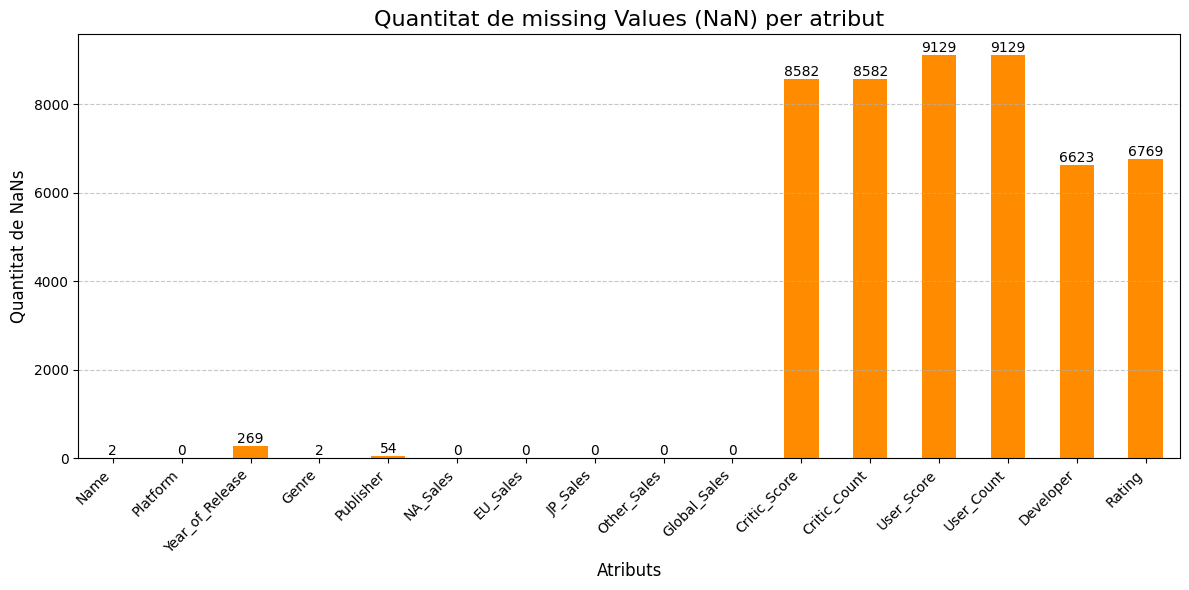

In [412]:
df['User_Score'] = df['User_Score'].replace('tbd', np.nan) #En la columna user score hay tbd. Esto transforma esos en NaNs
df['User_Score'] = pd.to_numeric(df['User_Score']) #Pasarlo a float64
df_fixed = df
mostrarGraficNaNs(df_fixed)


Una vegada fet aixó, podem començar a procesar els NaNs. Hem decidit utilitzar un SimplerImputer, on per omplir els valors numerics utilitzarem  la mediana i per les categoriques utilitzarem la moda.



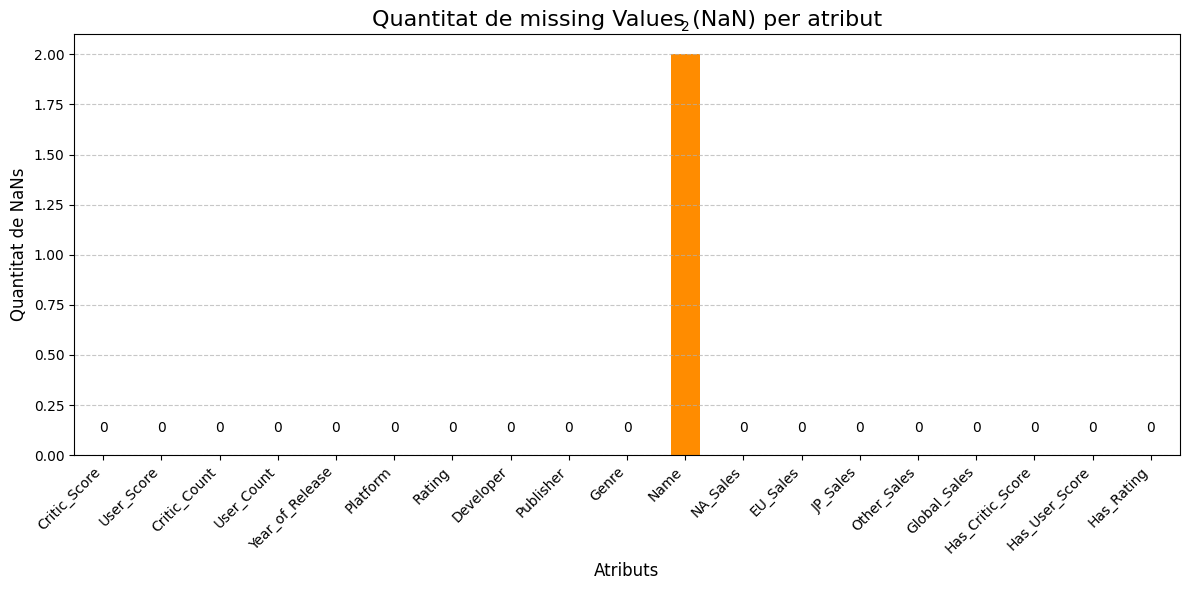

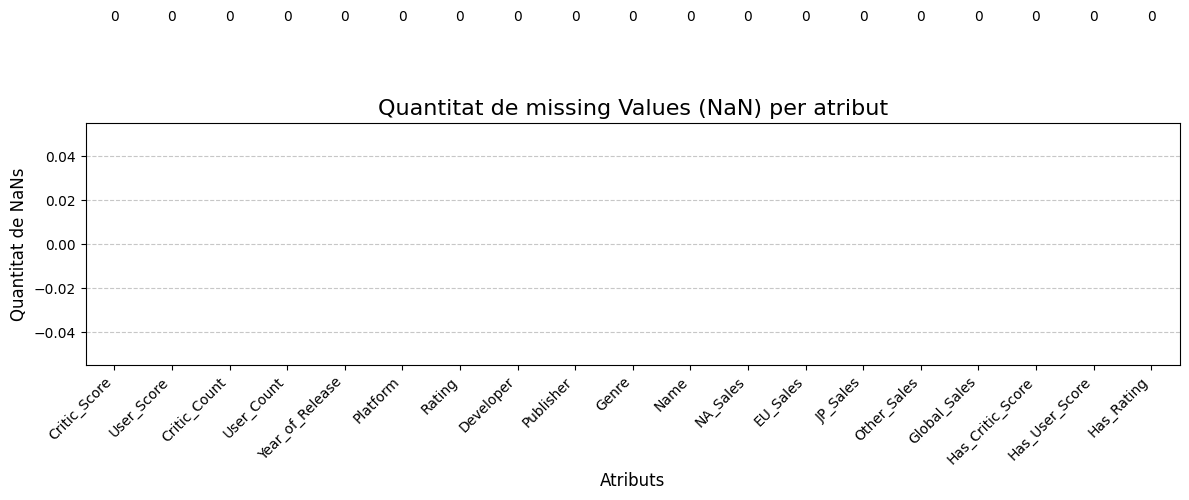

In [413]:
numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
categorical_features = ['Platform','Rating', 'Developer','Publisher', 'Genre']

df['Has_Critic_Score'] = df['Critic_Score'].notnull().astype(int)
df['Has_User_Score'] = df['User_Score'].notnull().astype(int)
df['Has_Rating'] = df['Rating'].notnull().astype(str)

numeric_imputed = IterativeImputer(max_iter=10, random_state=42, min_value=0).fit_transform(df[numeric_features])
df_numeric = pd.DataFrame(numeric_imputed, columns=numeric_features, index=df.index)

categorical_imputed = SimpleImputer(strategy='most_frequent').fit_transform(df[categorical_features])
df_categorical = pd.DataFrame(categorical_imputed, columns=categorical_features, index=df.index)

passthrough_cols = [col for col in df.columns if col not in numeric_features + categorical_features]
df_passthrough = df[passthrough_cols]

df_imputed = pd.concat([df_numeric, df_categorical, df_passthrough], axis=1)

mostrarGraficNaNs(df_imputed)

df_imputed = df_imputed.dropna()

mostrarGraficNaNs(df_imputed)


---
### Data scaling

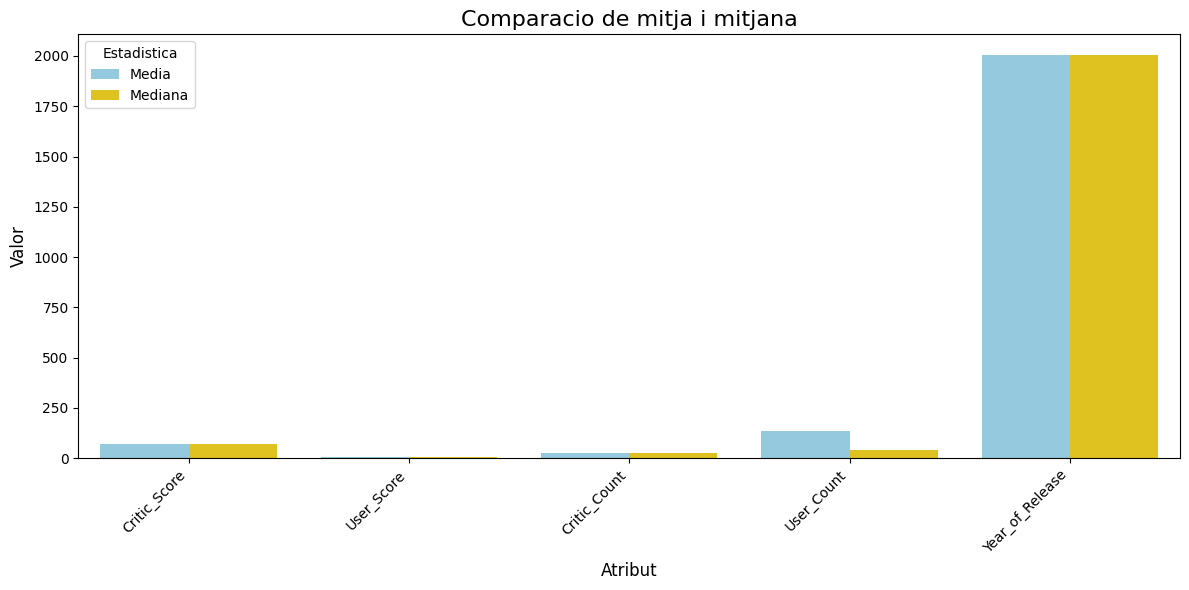

In [414]:
atributosNumericos = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count','Year_of_Release']

df_numeric_data = df_imputed[atributosNumericos]
df2 = df_imputed[atributosNumericos]
atributos_numericos = numeric_features
# -----------------------------------------------------
medias = df2[atributosNumericos].mean().rename('Media')
medianas = df2[atributosNumericos].median().rename('Mediana')

df_stats = pd.concat([medias, medianas], axis=1)

df_plot = df_stats.reset_index().melt(
    id_vars='index',
    var_name='Estadística',
    value_name='Valor'
)

df_plot = df_plot.rename(columns={'index': 'Atributo'})

plt.figure(figsize=(12, 6))

sns.barplot(
    x='Atributo',
    y='Valor',
    hue='Estadística',
    data=df_plot,
    palette={'Media': 'skyblue', 'Mediana': 'gold'}
)
plt.title('Comparacio de mitja i mitjana', fontsize=16)
plt.xlabel('Atribut', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.legend(title='Estadistica')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


Per evitar el biaix de caracteristiques i millorar la convergencia mes endavant quan començem a entrenar els models, probarem diferents scalers. (explicar)

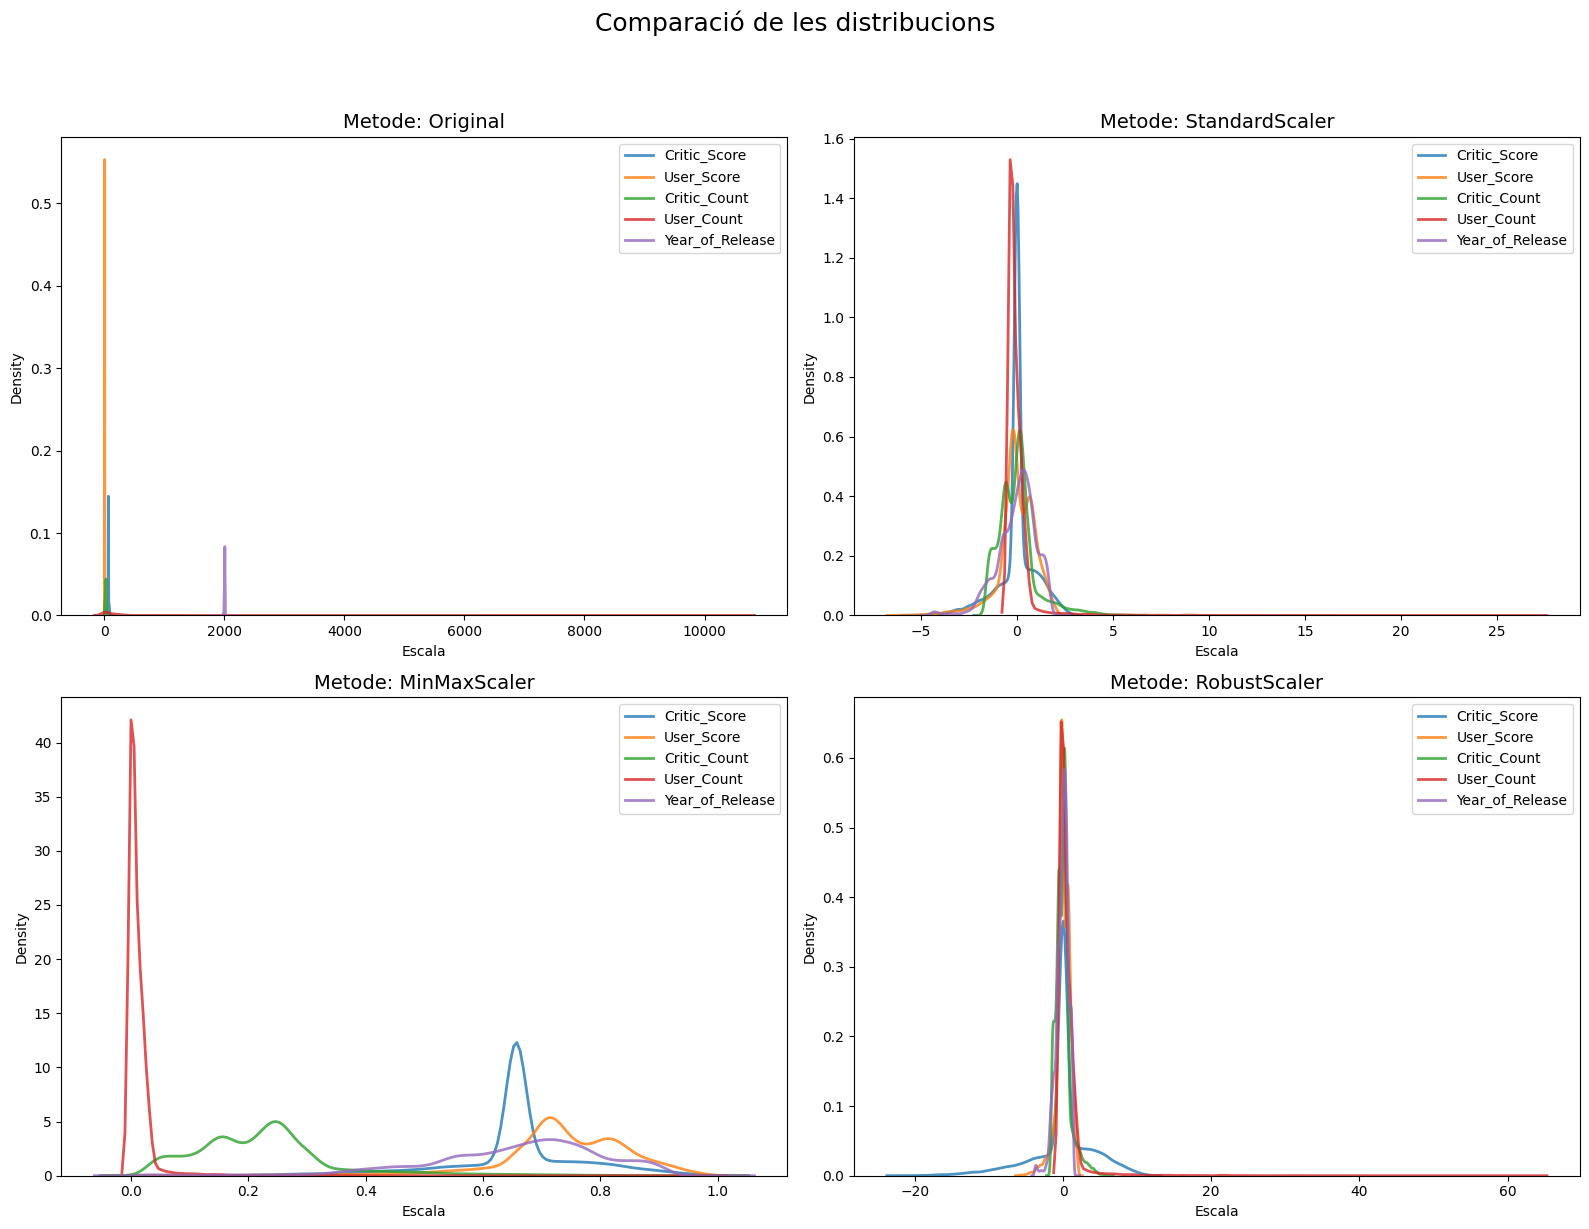

In [415]:
df_numeric_data = df_imputed[numeric_features]

scalers = {
    "Original": df_numeric_data.copy(),
    "StandardScaler": pd.DataFrame(StandardScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "MinMaxScaler": pd.DataFrame(MinMaxScaler().fit_transform(df_numeric_data), columns=numeric_features),
    "RobustScaler": pd.DataFrame(RobustScaler().fit_transform(df_numeric_data), columns=numeric_features)}

plot_cols = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']

plt.figure(figsize=(16, 12))
plt.suptitle('Comparació de les distribucions', fontsize=18, y=1.02)

for i, (name, scaled) in enumerate(scalers.items(), 1):
    plt.subplot(2, 2, i)
    for col in plot_cols:
         sns.kdeplot(scaled[col], fill=False, label=col, alpha=0.8, linewidth=2)

    plt.title(f'Metode: {name}', fontsize=14)
    plt.xlabel('Escala')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

df_scaled = df_imputed.copy()
df_scaled.update(scalers["RobustScaler"])



---
### Tractament de dades categóriques


Per altra banda, també hem de tractar els atributs categorics previament mencionats.

Si mirem la quantitat de valors unics per cada atribut (Platform, Rating, Developer, etc), podem veure que en developer y publisher hi ha una gran quantitat de valors unics. Codificar aquests amb un label/ordinal/onehot encoder pot donar problemes. Per solventar aixó, hem decidit tenir en compte els publishers. Amb aquests, els hem agrupat en 3 grups depenent del nombre de jocs que han publicat.
Per altra hem codificat el rating amb un ordinal encoder, de jocs per petits fins a nomes adults.
Per ultim, hem decidit aplicar onehot encoder al genere del joc.

In [416]:
columnas_categoricas = categorical_features

# 2. Iterar sobre las columnas y mostrar los valores únicos
for columna in columnas_categoricas:
    # Usamos .unique() para obtener la lista de valores únicos
    valores_unicos = df_scaled[columna].unique()

    # Imprimir el resultado
    print(f"\nAtribut: {columna}")
    print(f"Nombre de valors unics: {len(valores_unicos)}")
    # Se imprime solo una muestra para evitar listas muy largas
    print(f"Valors unics: {valores_unicos[:10]}")

    # Si la columna tiene muchos valores únicos, es mejor solo mostrar el conteo
    if len(valores_unicos) > 20:
        print(f"Hi ha mes de 20!")


Atribut: Platform
Nombre de valors unics: 31
Valors unics: ['Wii' 'NES' 'GB' 'DS' 'X360' 'PS3' 'PS2' 'SNES' 'GBA' 'PS4']
Hi ha mes de 20!

Atribut: Rating
Nombre de valors unics: 8
Valors unics: ['E' 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']

Atribut: Developer
Nombre de valors unics: 1696
Valors unics: ['Nintendo' 'Ubisoft' 'Good Science Studio' 'Rockstar North'
 'Polyphony Digital' 'Infinity Ward, Sledgehammer Games' 'Treyarch'
 'Infinity Ward' 'DMA Design' 'Game Arts']
Hi ha mes de 20!

Atribut: Publisher
Nombre de valors unics: 581
Valors unics: ['Nintendo' 'Microsoft Game Studios' 'Take-Two Interactive'
 'Sony Computer Entertainment' 'Activision' 'Ubisoft' 'Bethesda Softworks'
 'Electronic Arts' 'Sega' 'SquareSoft']
Hi ha mes de 20!

Atribut: Genre
Nombre de valors unics: 12
Valors unics: ['Sports' 'Platform' 'Racing' 'Role-Playing' 'Puzzle' 'Misc' 'Shooter'
 'Simulation' 'Action' 'Fighting']


In [417]:
publisher_counts = df_scaled.groupby('Publisher')['Name'].transform('count')

def classify_by_count(count):
    if count >= 1000:
        return 'Gegant'
    elif count >= 600:
        return 'Gran'
    elif count >= 300:
        return 'Mitja'
    elif count >= 50:
        return 'Petit'
    else:
        return 'Molt petit'

# 3. Aplicar la clasificación y crear la nueva característica segura
df_scaled['Publisher_Tier_Safe'] = publisher_counts.apply(classify_by_count)


# --- Resultados ---
print("Exemple de les primeres files:")
print(df_scaled[['Publisher', 'Publisher_Tier_Safe']].head(5))
print("\nQuantitat de Publishers per Tier:")
print(df_scaled['Publisher_Tier_Safe'].value_counts())
print("-" * 60)

Exemple de les primeres files:
  Publisher Publisher_Tier_Safe
0  Nintendo                Gran
1  Nintendo                Gran
2  Nintendo                Gran
3  Nintendo                Gran
4  Nintendo                Gran

Quantitat de Publishers per Tier:
Publisher_Tier_Safe
Gran          6437
Petit         3968
Molt petit    3379
Mitja         1523
Gegant        1410
Name: count, dtype: int64
------------------------------------------------------------


In [418]:
#ORDINAL ENCODER
rating_categories = [
    ['RP', 'EC', 'K-A', 'E', 'E10+', 'T', 'M', 'AO']
]
ordinal_encoder = OrdinalEncoder(categories=rating_categories)
rating_column = df_scaled[['Rating']]
rating_encoded_array = ordinal_encoder.fit_transform(rating_column)
df_scaled['Rating_Encoded'] = rating_encoded_array.flatten()
df_scaled.drop('Rating', axis=1, inplace=True)


cols_to_encode = ['Genre', 'Platform']
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_array = onehot_encoder.fit_transform(df_scaled[cols_to_encode])
new_cols = onehot_encoder.get_feature_names_out(cols_to_encode)
df_encoded = pd.DataFrame(
    encoded_array,
    columns=new_cols,
    index=df_scaled.index
)
df_scaled = pd.concat([df_scaled.drop(cols_to_encode, axis=1), df_encoded], axis=1)

print(df_scaled.columns)


Index(['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count',
       'Year_of_Release', 'Developer', 'Publisher', 'Name', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales',
       'Has_Critic_Score', 'Has_User_Score', 'Has_Rating',
       'Publisher_Tier_Safe', 'Rating_Encoded', 'Genre_Action',
       'Genre_Adventure', 'Genre_Fighting', 'Genre_Misc', 'Genre_Platform',
       'Genre_Puzzle', 'Genre_Racing', 'Genre_Role-Playing', 'Genre_Shooter',
       'Genre_Simulation', 'Genre_Sports', 'Genre_Strategy', 'Platform_2600',
       'Platform_3DO', 'Platform_3DS', 'Platform_DC', 'Platform_DS',
       'Platform_GB', 'Platform_GBA', 'Platform_GC', 'Platform_GEN',
       'Platform_GG', 'Platform_N64', 'Platform_NES', 'Platform_NG',
       'Platform_PC', 'Platform_PCFX', 'Platform_PS', 'Platform_PS2',
       'Platform_PS3', 'Platform_PS4', 'Platform_PSP', 'Platform_PSV',
       'Platform_SAT', 'Platform_SCD', 'Platform_SNES', 'Platform_TG16',
       'Platform_WS', '

---
## Selecció de mètriques
Una vegada preprocesades les dades, seleccionem la millor mètrica pel problema

MSE, RMSE,R^2

Errores grandes son catastróficos,RMSE,Penaliza fuertemente los outliers o grandes desviaciones debido al término cuadrático.

Todos los errores son iguales,MAE,Trata todas las desviaciones por igual; es la más fácil de explicar a personas sin conocimientos técnicos.

Necesitas un resumen del ajuste,R2,Te da el contexto de qué tan útil es tu modelo en comparación con un modelo base simple (la media).

---
## Selecció del model
Una vegada seleccionada la millor mètrica, seleccionarem el millor model pel problema

In [419]:
#Funcions utils adaptades a l'api de sklearn, ja q els utilitzem en el pipelining

numeric_features = ['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count', 'Year_of_Release']
rating_feature = ['Rating']
binary_features = ['Has_Critic_Score', 'Has_User_Score', 'Has_Rating']
rating_categories = [['RP', 'EC', 'K-A', 'E', 'E10+', 'T', 'M', 'AO']]
genre_platform_features = ['Genre', 'Platform']
publisher_feature = ['Publisher_Tier']
tier_categories = [['Molt petit', 'Petit', 'Mitja', 'Gran', 'Gegant']]

class UserScoreCleaner(BaseEstimator, TransformerMixin): #canvia esl tbd per nans a la columna user score i o pasa a float
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['User_Score'] = X['User_Score'].replace('tbd', np.nan)
        X['User_Score'] = pd.to_numeric(X['User_Score'])

        X['Has_Critic_Score'] = X['Critic_Score'].notnull().astype(int)
        X['Has_User_Score'] = X['User_Score'].notnull().astype(int)
        X['Has_Rating'] = X['Rating'].notnull().astype(int)
        return X

class PublisherBinner(BaseEstimator, TransformerMixin): #codifica els publishers
    def fit(self, X, y=None):
        self.publisher_counts_ = X['Publisher'].value_counts()
        return self

    def transform(self, X):
        X = X.copy()

        def classify(publisher):
            count = self.publisher_counts_.get(publisher, 0)
            if count >= 1000:
              return 'Gegant'
            elif count >= 600:
              return 'Gran'
            elif count >= 300:
              return 'Mitja'
            elif count >= 50:
              return 'Petit'
            else:
              return 'Molt petit'

        X['Publisher_Tier'] = X['Publisher'].apply(classify)

        cols_to_drop = [c for c in ['Name', 'Developer', 'Publisher'] if c in X.columns]
        X = X.drop(columns=cols_to_drop)
        return X


In [420]:
def construir_preprocesador():
    """Define y ensambla todos los pasos de preprocesamiento en un solo Pipeline."""

    # 1. Numérico: Imputar media + Indicador de Faltantes -> RobustScaler
    numeric_transformer = Pipeline(steps=[
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
        ('scaler', RobustScaler())
    ])

    # 2. Rating: Imputar moda -> OrdinalEncoder
    rating_transformer = Pipeline(steps=[
        ('encoder', OrdinalEncoder(categories=rating_categories, handle_unknown='use_encoded_value', unknown_value=-1)),
        ('imputer', IterativeImputer(max_iter=10, random_state=42, min_value=0)),
    ])

    # 3. Genre: Imputar moda -> OneHotEncoder
    genre_platform_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # 4. Publisher Tier: Imputar moda -> OrdinalEncoder
    publisher_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OrdinalEncoder(categories=tier_categories))
    ])

    # --- Unir todo en el ColumnTransformer ---
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('rating', rating_transformer, rating_feature),
            ('genre_platform', genre_platform_transformer, genre_platform_features),
            ('tier', publisher_transformer, publisher_feature),
            ('flags', 'passthrough', binary_features)
        ],
        remainder='drop'
    )

    # --- Pipeline de Preprocesamiento Final ---
    full_preprocessor_pipeline = Pipeline(steps=[
        ('cleaner', UserScoreCleaner()),
        ('binner', PublisherBinner()),
        ('preprocessor', preprocessor)
    ])

    return full_preprocessor_pipeline

In [421]:
def entrenar_modelos_no_lineales(df, target_col):
    """
    Ejecuta GridSearchCV para modelos de regresión NO lineales (SVR y XGBoost)
    y genera gráficos de evaluación.
    """
    print(f"--- Iniciando GridSearch (XGBOOST) para: {target_col} ---")

    # 1. Preparar datos
    sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
    X = df.drop(columns=sales_cols)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Obtener el Preprocesador Completo (Asumido)
    # Se asume que 'construir_preprocesador()' gestiona las transformaciones de las características
    preprocessor_pipeline = construir_preprocesador()

    # 3. Seleccionar Modelo y Parámetros

    xgb = XGBRegressor(
        random_state=42,
        n_jobs=-1,
        objective='reg:squarederror' # El objetivo estándar funciona bien con datos logarítmicos
    )

    # 4. Envolver el XGBoost con TransformedTargetRegressor
    # Esto se encarga del log1p antes de entrenar y expm1 después de predecir
    model_wrapper = TransformedTargetRegressor(
        regressor=xgb,
        func=np.log1p,       # Transformación: log(1 + x)
        inverse_func=np.expm1 # Inversa: exp(x) - 1
    )

    # 5. Pipeline Final
    # Nota: El wrapper va al final del pipeline
    full_pipeline = Pipeline(steps=[
        ('preproc', preprocessor_pipeline),
        ('model', model_wrapper)
    ])

    param_grid = {
        'model__regressor__n_estimators': [100, 200, 300, 500],
        'model__regressor__learning_rate': [0.01, 0.05, 0.1],
        'model__regressor__max_depth': [3, 4, 5, 7],
        'model__regressor__subsample': [0.7, 0.9],
        'model__regressor__colsample_bytree': [0.7, 0.9],
        'model__regressor__gamma': [0.1, 0.2, 0.5, 1, 5, 10],
        'model__regressor__min_child_weight': [3, 5, 10, 20, 50]
    }


    # 5. Configurar y Ejecutar GridSearchCV
    grid_search = RandomizedSearchCV(
        estimator=full_pipeline,
        param_distributions=param_grid,
        n_iter=30,
        cv=3,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    print(f"Ejecutando GridSearch para XGBOOST...")
    grid_search.fit(X_train, y_train)

    # 6. Resultados (Métricas)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    # 7. Evaluación Final (Impresión de resultados)
    print(f"\nMejores parámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor MAE en Validación Cruzada: {abs(grid_search.best_score_):.4f}")
    print(f"MAE test: {test_mae:.4f}")
    print(f"R2 test: {test_r2:.4f}")

    # --- 8. GENERACIÓN DE GRÁFICOS SEABORN ---

    # Creamos un DataFrame para graficar
    results_df = pd.DataFrame({
        'Real': y_test,
        'Predicho': y_pred,
        'Residuo': y_test - y_pred # Residuo = Real - Predicho
    })

    plt.figure(figsize=(20, 6))

    # --- Gráfico 1: Valores Reales vs. Predichos escala completa ---
    plt.subplot(1, 3, 1) # 1 fila, 3 columnas, posición 1
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4)

    # Línea perfecta de predicción (donde Real = Predicho)
    max_val = results_df[['Real', 'Predicho']].max().max()
    plt.plot([0, max_val], [0, max_val], 'r--', lw=2)

    plt.title(f'Escala completa: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 2: Valores Reales vs. Predichos zoom ---
    plt.subplot(1, 3, 2)
    sns.scatterplot(x='Real', y='Predicho', data=results_df, alpha=0.4, color='g')

    plt.plot([0, 5], [0, 5], 'r--', lw=2)

    # ZOOM
    plt.xlim(0, 5)
    plt.ylim(0, 5)

    plt.title(f'Zoom: Real vs Predicho', fontsize=12)
    plt.xlabel('Real Sales')
    plt.ylabel('Predicted Sales')
    plt.grid(True, alpha=0.3)

    # --- Gráfico 3: Distribución de Residuos ---
    plt.subplot(1, 3, 3) # 1 fila, 2 columnas, posición 2
    sns.histplot(results_df['Residuo'], bins=30, kde=True, color='skyblue')

    # Línea en Residuo = 0
    plt.axvline(x=0, color='red', linestyle='--')

    plt.title(f'Distribución de Residuos | XGBOOST', fontsize=14)
    plt.xlabel('Residuo (Error)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)

    plt.tight_layout() # Ajusta el layout para que no se superpongan
    plt.show() # Muestra los dos gráficos

    return best_model

Resultats per: Global_Sales
--- Iniciando GridSearch (XGBOOST) para: Global_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.3577
MAE test: 0.3832
R2 test: 0.1934


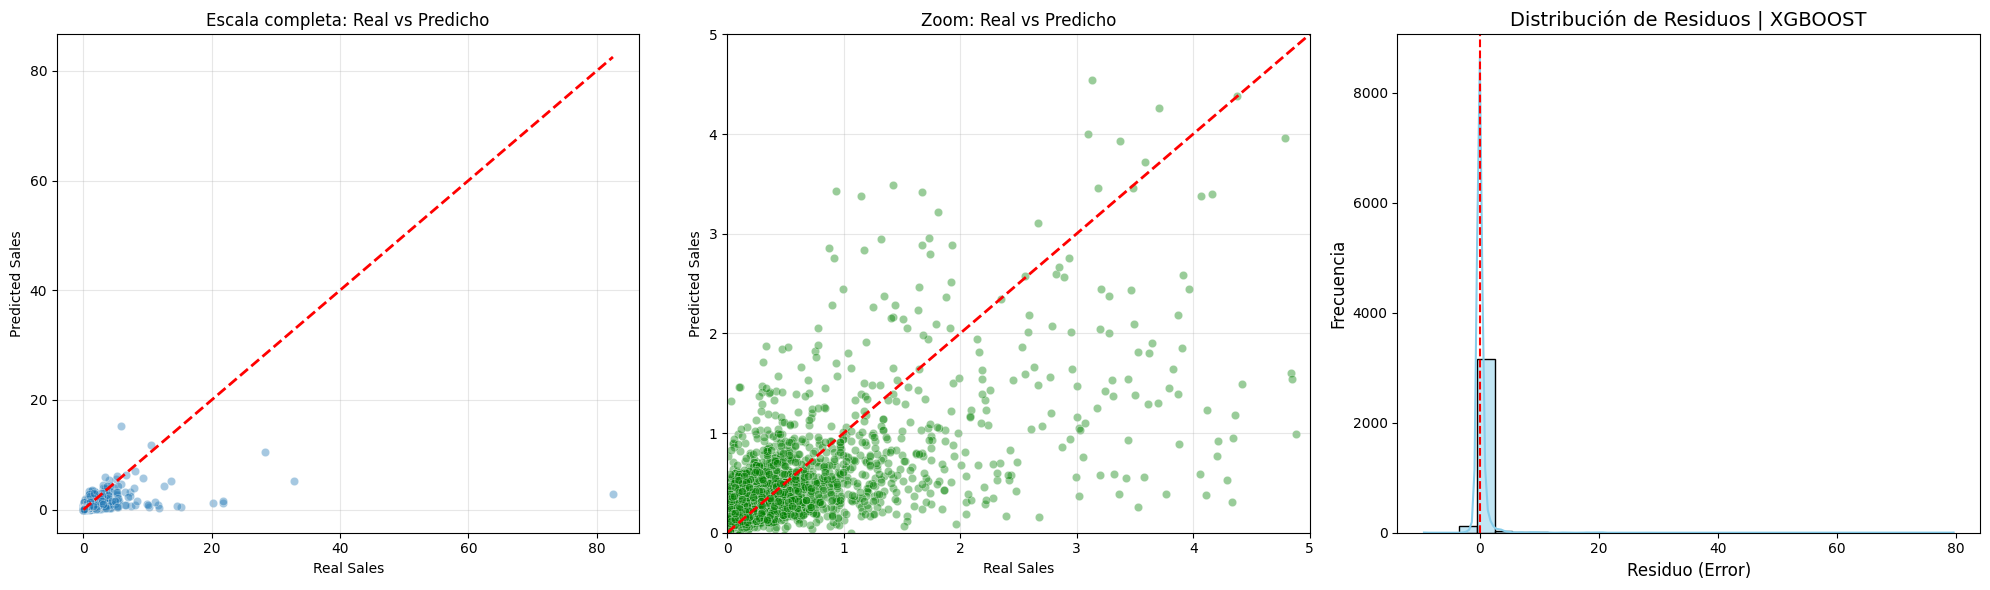

Resultats per: NA_Sales
--- Iniciando GridSearch (XGBOOST) para: NA_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.1951
MAE test: 0.2038
R2 test: 0.1855


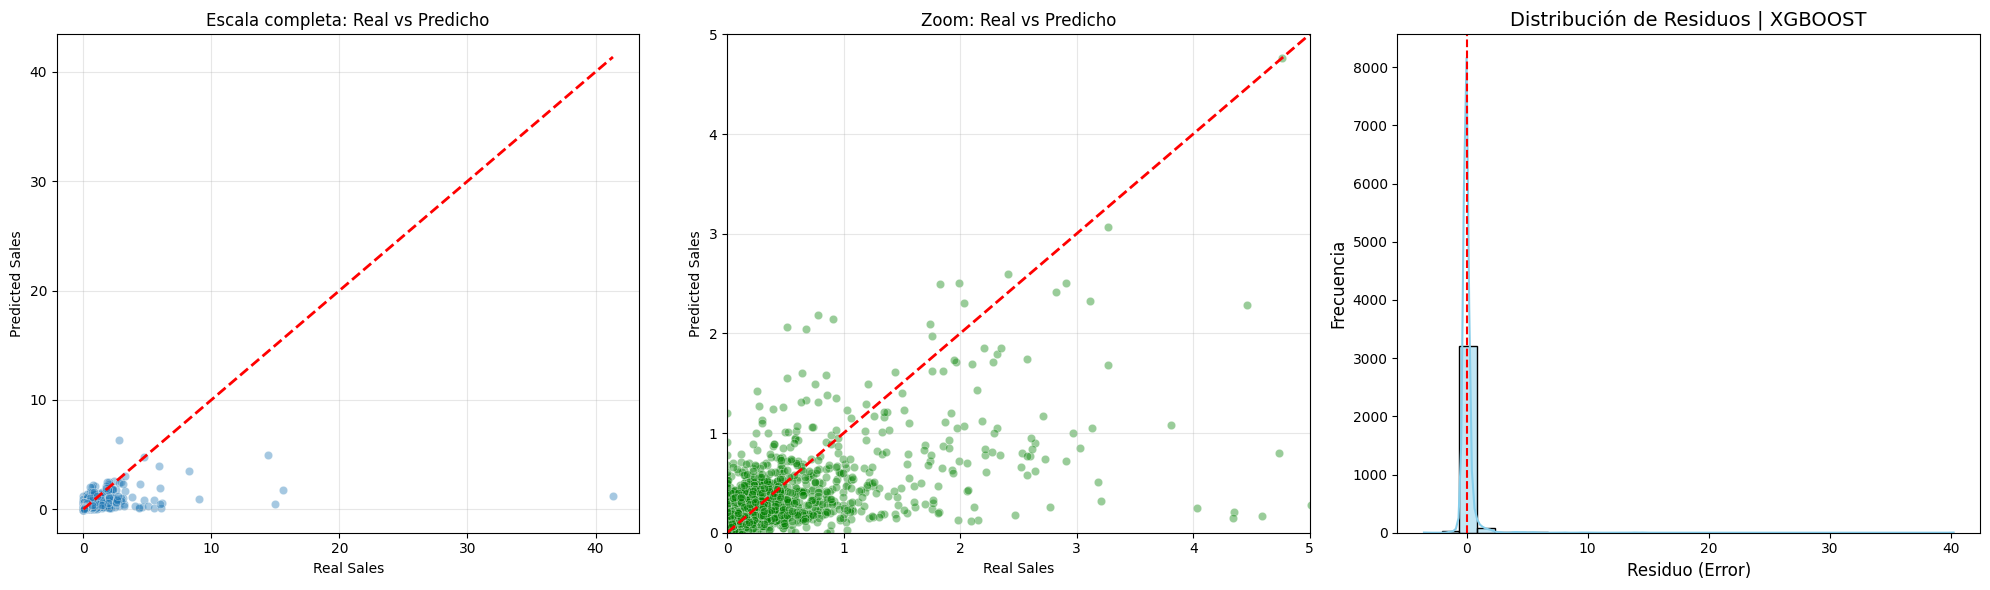

Resultats per: EU_Sales
--- Iniciando GridSearch (XGBOOST) para: EU_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.1225
MAE test: 0.1356
R2 test: 0.1607


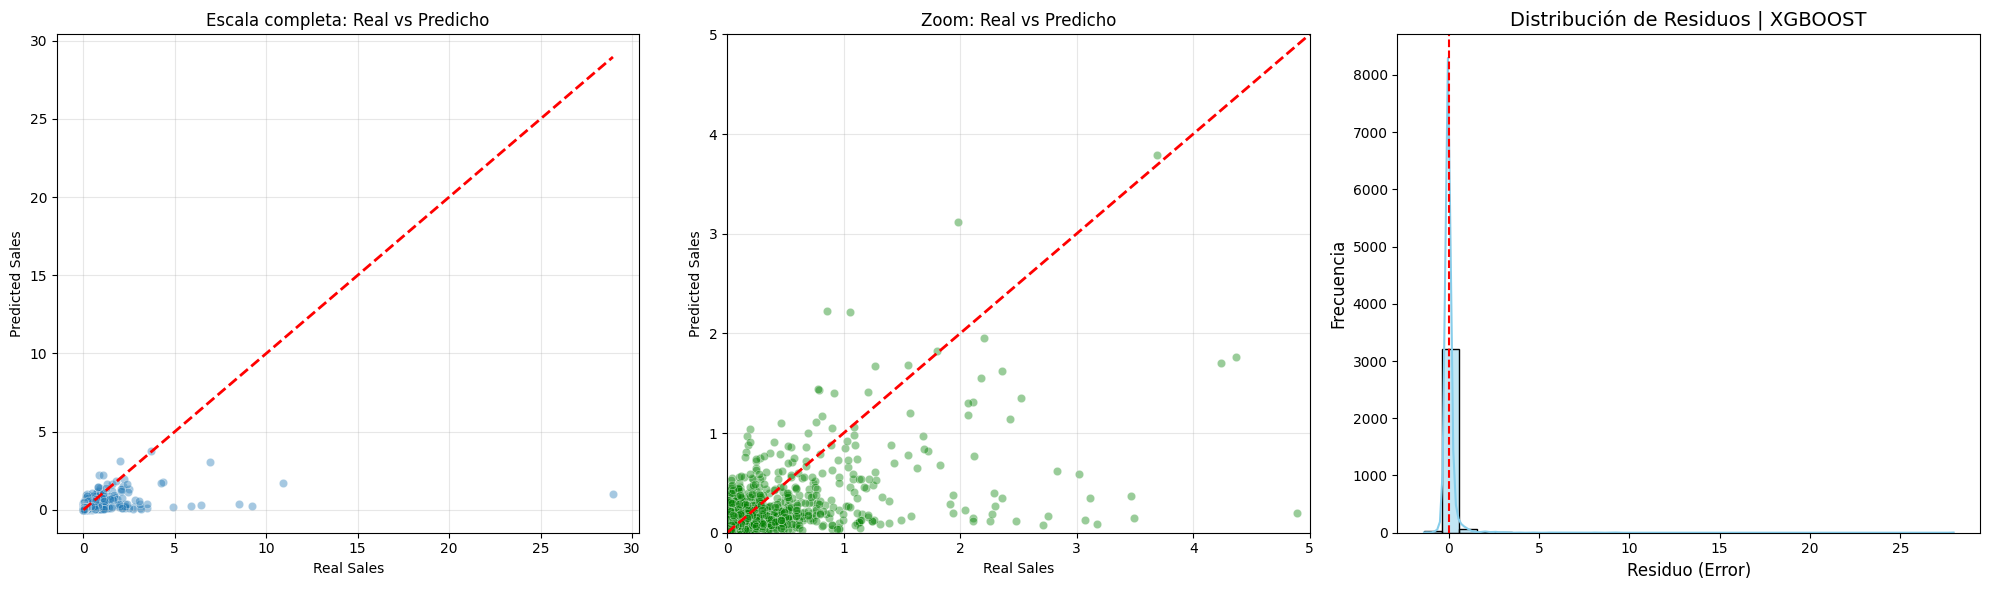

Resultats per: JP_Sales
--- Iniciando GridSearch (XGBOOST) para: JP_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.0763
MAE test: 0.0806
R2 test: 0.2436


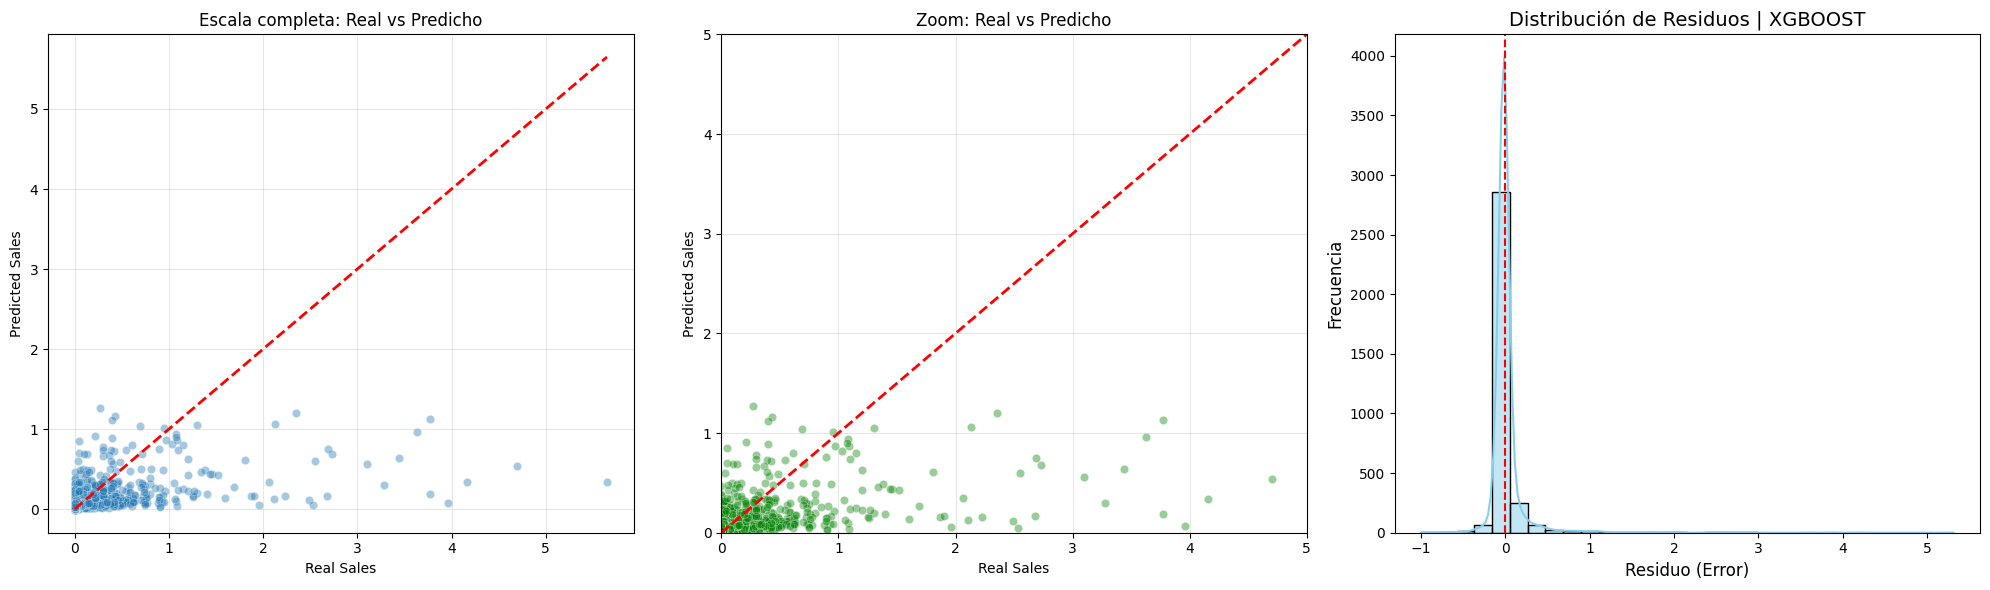

Resultats per: Other_Sales
--- Iniciando GridSearch (XGBOOST) para: Other_Sales ---
Ejecutando GridSearch para XGBOOST...
Fitting 3 folds for each of 30 candidates, totalling 90 fits

Mejores parámetros encontrados: {'model__regressor__subsample': 0.9, 'model__regressor__n_estimators': 200, 'model__regressor__min_child_weight': 5, 'model__regressor__max_depth': 7, 'model__regressor__learning_rate': 0.05, 'model__regressor__gamma': 0.1, 'model__regressor__colsample_bytree': 0.9}
Mejor MAE en Validación Cruzada: 0.0410
MAE test: 0.0420
R2 test: 0.2083


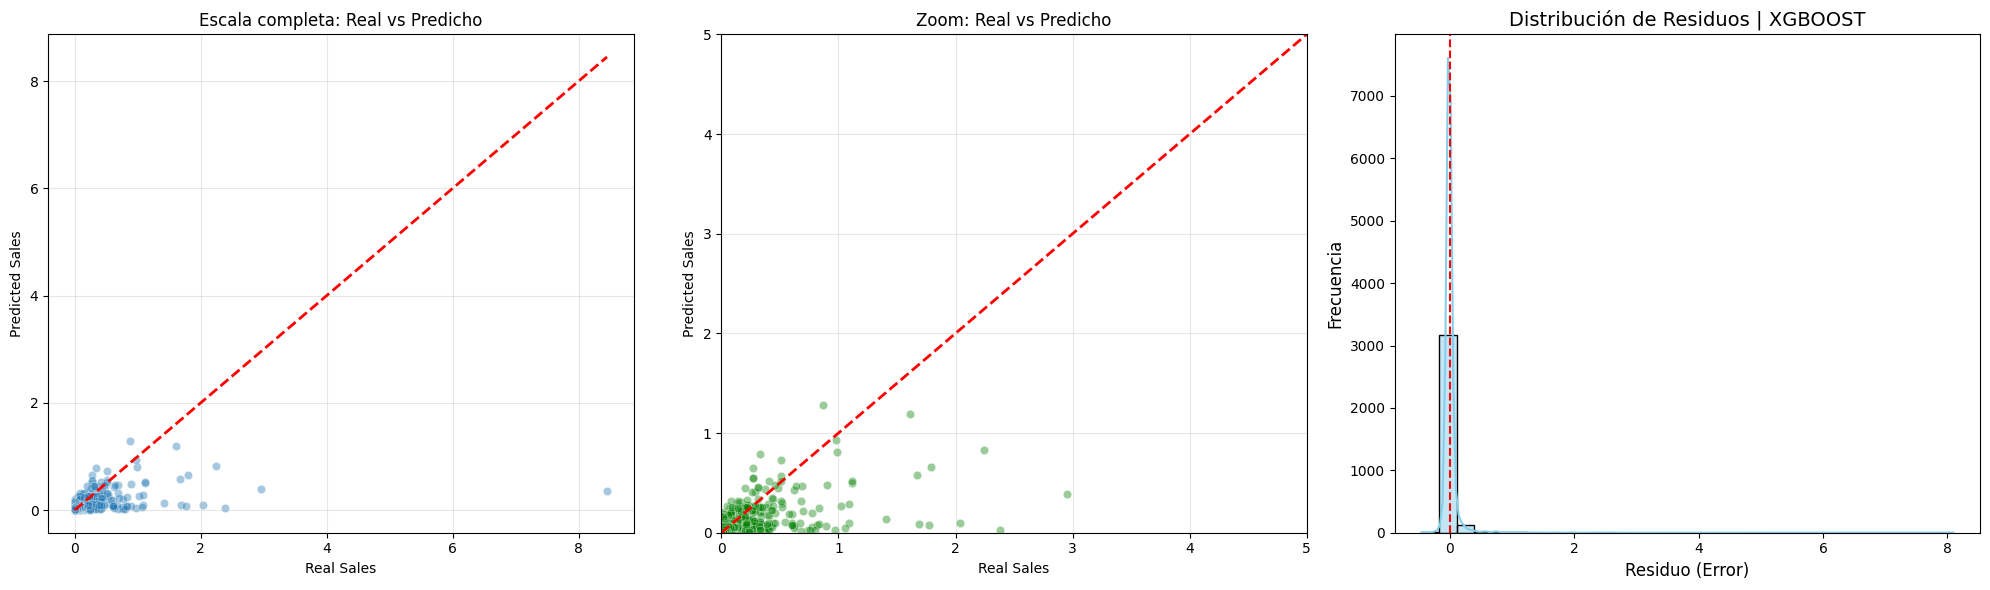

In [422]:
targets = ['Global_Sales','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for t in targets:
  print("Resultats per: " + t)
  model_xgboost = entrenar_modelos_no_lineales(df, target_col=t)

---
## Anàlisis final
Inicialmente hemos notado que los modelos no lineales (svr, xgboost) dan resultados bastante más acertados que los lineales. En cuanto a estos primeros, la svg da peores resultados que el xgboost, tardando un tiempo de entrenamiento mucho mayor. Aún así, los valores de R2 y el error siguen estando por debajo de lo esperado.

Todo esto se puede explicar entendiendo mejor los datos con los que estamos tratando. Las ventas de los juegos no se distribuyen de forma lineal, si no que hay pocos que venden millones y muchos que venden poco. Esto encaja mejor con un crecimiento logarítmico.

Para hacer que los modelos se adapten mejor a este crecimiento, vamos a tratar los datos de forma logarítmica. Vamos a dividir el proyecto en 2 ramas, modelos lineales y no lineales.
Para los modelos lineales, vamos a intentar calcular el logaritmo de las ventas en lugar de las própias ventas. Esto debería mejorar mucho su rendimiento. También cambiaremos ridge y lasso por elasticnet, que se adapta mejor a los polinomios. Aún así, somos conscientes de sus limitaciones y de que seguramente darán peores resultados que los no lineales.
En cuanto a los no lineales, vamos a eliminar la svm e intentar que la xgboost sea lo más precisa posible. Cambiaremos su función para que se adapte al comportamiento polinómico de los datos y aprenda más lentamente pero de forma más sólida. También modificaremos un poco el preprocesamiento para maximizar la información que recibe el modelo, ya que al no usar svm ya no hará falta simplificarlo tanto.